In [11]:
#%matplotlib notebook
%matplotlib inline

# https://stackoverflow.com/questions/43599018/is-there-a-way-to-get-matplotlib-path-contains-points-to-be-inclusive-of-boundar
#I do quite like this command in Jupiter notebook:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
#It makes things wider and not waste the space on your screen
import pandas as pd
import importlib
import csv,os
import numpy as np
import pandas as pd
import itertools
import pyproj
import shapely
import copy
from uafgi import gicollections,cfutil,glacier,gdalutil,shputil,pdutil
import uafgi.data.ns642
import netCDF4
import matplotlib.pyplot as plt
import uafgi.data.wkt
import uafgi.data.w21 as d_w21
map_wkt = uafgi.data.wkt.nsidc_ps_north
pd.set_option("display.max_rows", 30, "display.max_columns", None)
pd.set_option("display.max_rows", 200, "display.max_columns", None)

from uafgi.data import d_velterm
import uafgi.data.stability as d_stability
import scipy

In [7]:
importlib.reload(d_velterm)
importlib.reload(d_stability)
select = d_stability.read_select(map_wkt)
velterm_df = d_velterm.read()



Index(['fj_fid', 'fj_poly', 'fj_key'], dtype='object')
Index(['ft_ftid', 'ft_terminus', 'ft_key', 'fj_fid'], dtype='object')


In [6]:
velterm_df

,vel_year,future_index,term_year,terminus,aflux,sflux,ncells,up_area,fluxratio,glacier_id
0,1985.498516,NaN,1985.358790,None,0.010735,1265.203756,41,70410000.0,117855.517091,1
1,1985.498516,NaN,1985.665639,None,0.014532,2942.982580,49,69010000.0,202519.308686,1
2,1985.498516,NaN,1986.254795,None,0.013662,2680.441972,48,70020000.0,196196.205429,1
3,1985.498516,NaN,1986.717694,None,0.012835,2674.742741,41,69330000.0,208397.622108,1
4,1985.498516,NaN,1987.375228,None,0.012835,2674.742741,41,69980000.0,208397.622108,1
...,...,...,...,...,...,...,...,...,...,...
1525,2018.498516,0.0,2020.000000,None,0.006788,1094.510771,49,22910000.0,161240.915691,226
1526,2018.498516,1.0,2021.000000,None,0.008010,1056.532875,47,18950000.0,131894.835841,226
1527,2018.498516,2.0,2022.000000,None,0.006607,915.843643,46,14560000.0,138624.499097,226
1528,2018.498516,3.0,2023.000000,None,0.003611,441.458446,49,10790000.0,122244.735637,226


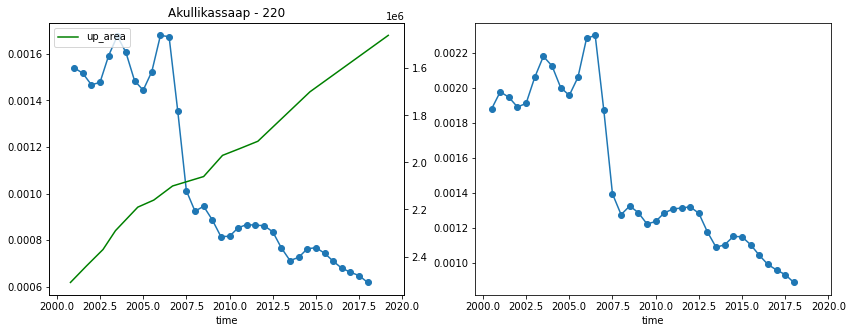

In [13]:
    # Glaciers that have shown consistent retreat
    retreat_ids = {220, 18, 82, 148, 181, 212, 37, 186, 15, 164, 168, 204, 1, 203, 10, 197, 20, 196, 195, 192, 68, 50, 48, 173, 172, 171, 170, 169, 7, 103, 199}

    for nplots,(_,selrow) in enumerate(select.df.iterrows()):
        
        glacier_id = selrow['w21t_glacier_number']
        if glacier_id not in retreat_ids:
            continue
            
        fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(14,5))

        glacier_df0 = velterm_df[velterm_df.glacier_id == glacier_id]
    #    glacier_df = glacier_df[glacier_df['future_index'].isna()]
        glacier_df = glacier_df0[glacier_df0.term_year < 2020]
        
        # Past velocities: look back
        df = glacier_df[
            (glacier_df['term_year'] > 2000) & (glacier_df.term_year < 2020)]
        df = df[df.vel_year < df.term_year]
        df = df[['term_year', 'fluxratio']].groupby('term_year').mean()
        df = df.rename(columns={'fluxratio':'past'}).reset_index()

        pastfn = scipy.interpolate.interp1d(df.term_year, df.past,
            kind='cubic', bounds_error=False, fill_value=np.nan)


        # aflux (glacier advection) by year
        df = glacier_df0
        df = df[(df.vel_year > 2000) & (df.vel_year < 2020) & (df.term_year == 2021)]
        df = df[['vel_year', 'aflux']]
    #    df = df.sort_values(['vel_year']).drop_duplicates('vel_year')[['vel_year','aflux']]
    #    print(df['vel_year'])
        afluxfn = scipy.interpolate.interp1d(df.vel_year, df.aflux,
            kind='cubic', bounds_error=False, fill_value=np.nan)

    #    df.set_index('vel_year').plot(ax=ax2,color='purple') 

        # Interpolate to common points
        timepoints = np.linspace(2000, 2020, 41)
        alldf = pd.DataFrame(data={
            'time': timepoints, 'past': pastfn(timepoints), 'aflux':afluxfn(timepoints)})
        alldf = alldf.set_index('time')
        # advection * sigma / sigma_max
        alldf['adv_calv'] = alldf['aflux'] - (alldf['aflux'] * alldf['past'] * (1. / 300000.))
        plt.ioff()

        
        alldf['adv_calv'].plot(marker='o',ax=ax1)
        alldf['aflux'].plot(marker='o',ax=ax2)
        # https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/two_scales.html
        axr = ax1.twinx()
        # Plot cumulative retreat
        df = glacier_df.sort_values(['term_year']).drop_duplicates('term_year')[['term_year','up_area']]
        df = df[df.term_year > 2000]
        #print(df['term_year'])
        df.set_index('term_year').plot(ax=axr,color='g').invert_yaxis()
        



    #    # Plot Wood et al melt data
    #    rdf = d_w21.glacier_rate_df(selrow['w21_data_fname'])
    #    rdf = rdf.loc[(rdf.index > 2000)]
    #    rdf = rdf[['ice_advection']]
    #    rdf.plot(color='purple', ax=ax2)


        
    #    # Plot Wood et al retreat rate data
    #    # (but it's too choppy)
    #    rdf = d_w21.glacier_rate_df(selrow['w21_data_fname'])
    #    rdf = rdf[['calving']]
    #    # Index is time, and we want to add .5
    #    rdf.plot(ax=axr, color='g')


    #    # Plot the smoothed derivative of the retreat
    #    up_df = glacier_df.sort_values(['term_year']).drop_duplicates('term_year')[['term_year','up_area']]
    #    if len(up_df) > 5:
    #        #up_df = up_df.set_index('term_year')
    #        spl = scipy.interpolate.UnivariateSpline(up_df['term_year'], up_df['up_area'], s=5e10)
    #        xs = np.linspace(1986.,2019,200)
    #        retreat_rate = spl.derivative()(xs)
    #        retreat_df = pd.DataFrame({'term_year':xs, 'retreat_rate':retreat_rate})
    #        retreat_df = retreat_df.set_index('term_year')
    #    #    print(retreat_rate)
    #    #    plt.plot(xs, retreat_rate, 'g', ax=axr)
    #        retreat_df.plot(ax=axr,color='g')

    #spl.set_smoothing_factor(.001)
    #xs = np.linspace(1985,2020,200)
    #xs = np.linspace(2009.5,2020,200)
    #plt.plot(xs,spl.derivative()(xs), 'g')

     

        plt.title('{} - {}'.format(selrow['w21t_Glacier'], glacier_id))

        break
        if nplots > 20:
            break
        
    plt.show()


In [82]:
import cartopy

In [ ]:
# https://geohackweek.github.io/visualization/03-cartopy/
import cartopy.crs as ccrs                   # import projections
import cartopy.crs
import cartopy.feature as cf                 # import features
import pyproj.crs
from uafgi import gdalutil
import uafgi.data
from cartopy.io import shapereader

_EPSGProjection(3413)

(-50000000.0, 50000000.0)
(-218150.0, 100.0, 0.0, -2149950.0, 0.0, -100.0)
POLYGON ((-54.64459007523681 81.96156890434858, -53.71837605907077 81.78092167758996, -54.37939594256168 81.60961723328595, -54.3474968798491 81.51736643143948, -53.92792468568458 81.4694730087329, -53.70716453811731 81.42725598142952, -53.98825734495284 81.28225715271778, -53.7929839966489 81.13625095787923, -54.1628169802996 81.12022915370466, -54.45388076310468 81.26377105705771, -54.20818782768325 81.40144149471678, -54.91071204511729 81.4399768108551, -54.95461912407438 81.63750568514207, -54.62460514536021 81.77930116239847, -54.64459007523681 81.96156890434858))
extents: [-218150.0, -163150.0, -2149950.0, -2218150.0]
[-218150.0, -163150.0, -2149950.0, -2218150.0]


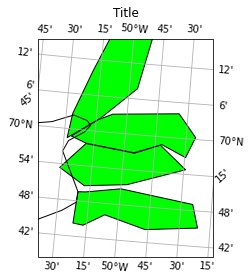

In [239]:
importlib.reload(cartopy.mpl.geoaxes)

importlib.reload(cartopy.crs)



class _SubProj(cartopy._epsg._EPSGProjection):
    # https://stackoverflow.com/questions/54569028/ignore-projection-limits-when-setting-the-extent
    @property
    def y_limits(self):
        return (-5e9,5e9)


map_crs = cartopy.crs.epsg(3413)
# https://stackoverflow.com/questions/31590152/monkey-patching-a-property
map_crs.__class__ = _SubProj
map_crs


map_crs = cartopy.crs.Stereographic(
        central_latitude=90,
        central_longitude=-45,
        false_easting=0, false_northing=0,
        true_scale_latitude=70, globe=None)



# ---------------------------

# https://pyproj4.github.io/pyproj/stable/crs_compatibility.html
map_wkt = uafgi.data.wkt.nsidc_ps_north

#map_crs = cartopy.crs.epsg(3413)
#map_crs.bounds = (-50000000.0, 50000000.0, -50000000.0, 50000000.0)
print(map_crs.x_limits)
ll_crs = ccrs.PlateCarree()


grid = 'W69.95N'
grid_file = uafgi.data.measures_grid_file(grid)

#with netCDF4.Dataset(grid_file) as nc:
#    ps = nc.variables['polar_stereographic']
#
#    #crs = ccrs.NorthPolarStereo(central_longitude=-45.)
#    crs = cartopy.crs.Stereographic(
#        central_latitude=ps.latitude_of_projection_origin,
#        #central_latitude=ps.standard_parallel,
#        central_longitude=ps.straight_vertical_longitude_from_pole,
#        false_easting=ps.false_easting, false_northing=ps.false_northing,
#        true_scale_latitude=None, globe=None)
#
## https://nsidc.org/data/polar-stereo/ps_grids.html    
#crs = cartopy.crs.epsg(3413)
    
gs = gdalutil.FileInfo(grid_file)
print(gs.geotransform)


geoTransform = gs.geotransform
x0 = geoTransform[0]
x1 = x0 + geoTransform[1] * gs.nx

y0 = geoTransform[3]
y1 = y0 + geoTransform[5] * gs.ny

# W68.60N_grid
#GeoTransform = GT = [-235050, 100, 0, -2290050, 0, -100]
#nx=730xn
#ny=760


fjord_outlines = '/Users/eafischer2/data_sets/velocities_data/fj/fjord_outlines.shp'

# Read shape file
#wgs84_crs = cartopy.crs.epsg(4326)     # Coord system of THIS shapefile
# https://scitools.org.uk/cartopy/docs/v0.8/crs/index.html
#wgs84_crs = cartopy.crs.Geodetic()
reader = shapereader.Reader(fjord_outlines)
## Filter for a specific country
fjords = [x.geometry for x in reader.records()]
print(fjords[1])
shape_feature = cf.ShapelyFeature(fjords, ll_crs, facecolor="lime", edgecolor='black', lw=1)

#mypoint = shapely.geometry.Point(-55,70.)
#print(mypoint)
#shape_feature = cf.ShapelyFeature([mypoint], ccrs.PlateCarree(), facecolor="lime", edgecolor='black', lw=1)



ax = plt.axes(projection = map_crs)  # create a set of axes with Mercator projection




# Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
extents = [x0,x1,y0,y1]
print('extents: {}'.format(extents))
#extents[3] = -2280000
print(extents)
#extents = (x0-1e6,x0+1e6,y0,0)      # Much of Greenland
ax.set_extent(extents=extents, crs=map_crs)
#ax.tissot(lats=range(43, 51), lons=range(-124, -116), alpha=0.4, rad_km=20000, color='orange')
ax.add_feature(shape_feature)
#ax.add_feature(cf.COASTLINE)                 # plot some data on them
ax.coastlines(resolution='50m')

#ax.stock_img()

# https://scitools.org.uk/cartopy/docs/latest/matplotlib/gridliner.html
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Here's plotting raseter data...
# https://scitools.org.uk/cartopy/docs/v0.16/tutorials/understanding_transform.html

ax.scatter([-55],[75], color='blue',s=20,transform=ll_crs)

ax.set_title("Title")                        # label it
plt.show()

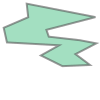

In [237]:
fjords[1]

In [227]:
# Cartopy extent on EPSG:3413 is wrong
# https://stackoverflow.com/questions/54569028/ignore-projection-limits-when-setting-the-extent
    
import pyproj

class _SubProj(cartopy._epsg._EPSGProjection):
    @property
    def y_limits(self):
        return (-17.,17.)


cs = cartopy.crs.Stereographic(
        central_latitude=70.,
        central_longitude=-45.,
        false_easting=0., false_northing=-2179601.924020097+7819.208384436018,
        true_scale_latitude=None, globe=None)
cs = cartopy.crs.epsg(3413)
# https://stackoverflow.com/questions/31590152/monkey-patching-a-property
cs.__class__ = _SubProj

print(type(cs))
print(cs.proj4_params)

cl = ccrs.PlateCarree()

print(type(cs))
print(cs.x_limits, cs.y_limits)

p4str = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs '
ps = pyproj.CRS(p4str)
pl = pyproj.CRS.from_proj4("+proj=latlon")
ptrans = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:3413')

for lon,lat in [(-50.,70.)]:
    print()
    print(ptrans.transform(lat,lon))
    print(cs.transform_point(lon,lat,cl))

<class '__main__._SubProj'>
{'datum': 'WGS84', 'ellps': 'WGS84', 'proj': 'stere', 'lat_0': '90', 'lat_ts': '70', 'lon_0': '-45', 'k': '1', 'x_0': '0', 'y_0': '0', 'units': 'm', 'no_defs': None}
<class '__main__._SubProj'>
(-2349829.1623399747, 0.0) (-17.0, 17.0)

(-190690.45935105087, -2179601.924020097)
(-190690.45935105087, -2179601.924020097)


In [2]:
import cartopy
map_crs = cartopy.crs.Stereographic(
        central_latitude=90,
        central_longitude=-45,
        false_easting=0, false_northing=0,
        true_scale_latitude=70, globe=None)
print(map_crs.proj4_params)

{'ellps': 'WGS84', 'proj': 'stere', 'lat_0': 90, 'lon_0': -45, 'x_0': 0, 'y_0': 0, 'lat_ts': 70}
